In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from model import LinearRegression
from utils import train_test_split, standardize, standardize_targets

In [2]:
data = pd.read_csv('FoDS-Assignment-2.csv')
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
0,4,1.75,2120.0,7420,1.0,0,0,4,7,1060.0,1060,1540,7420,453000.0
1,4,2.50,2180.0,9861,2.0,0,2,3,8,2180.0,0,2390,9761,480000.0
2,3,1.50,1540.0,9800,1.0,0,0,3,7,1010.0,530,1600,8250,180500.0
3,3,3.50,2380.0,6250,2.0,0,3,3,8,1670.0,710,2540,4010,495000.0
4,4,2.50,2230.0,8500,2.0,0,0,3,8,2230.0,0,2270,8770,325000.0


In [3]:
PREPROCESS = True

# Dataset Analysis

# Handling missing values

In [4]:
data.isnull().sum()

bedrooms          0
bathrooms         0
sqft_living      14
sqft_lot          0
floors           13
waterfront        0
view              0
condition         0
grade             0
sqft_above       14
sqft_basement     0
sqft_living15     0
sqft_lot15        0
price             0
dtype: int64


## Imputation technique: Impute missing values with mean

In [5]:
if PREPROCESS:
    data['sqft_living'] = data['sqft_living'].replace(np.NaN, data['sqft_living'].mean())
    data['floors'] = data['floors'].replace(np.NaN, data['floors'].mean())
    data['sqft_above'] = data['sqft_above'].replace(np.NaN, data['sqft_above'].mean())

else:
    data.dropna(subset=["sqft_living", "floors", "sqft_above"], inplace=True)

In [6]:
X = data.iloc[:, :-1].to_numpy().T
y = data.iloc[:, -1].to_numpy().reshape(-1, 1)

In [7]:
# Dataset Details
X.shape, y.shape

((13, 1188), (1188, 1))

# Outlier Detection

In [8]:
center = np.mean(X, axis=1, keepdims=True)
euclidean_distance = np.linalg.norm((X - center), ord=2, axis=0)

In [9]:
np.mean(euclidean_distance), np.max(euclidean_distance), np.min(euclidean_distance)

(18961.199216798053, 1686824.3691954182, 1236.7105832029372)

Text(0.5, 1.0, 'Outlier Detection')

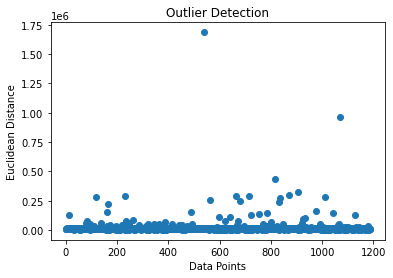

In [10]:
plt.scatter(range(len(euclidean_distance)), euclidean_distance)
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.title("Outlier Detection")

In [11]:
outliers_count = np.sum(euclidean_distance > 25 * np.mean(euclidean_distance))
outliers_count

2

In [12]:
if PREPROCESS:
    outliers = euclidean_distance > 25 * np.mean(euclidean_distance)
    outliers_idx = np.argwhere(outliers == 1)
    A = X
    for idx in outliers_idx.squeeze():
        A = np.delete(A, idx, 1)

    X = A 

In [13]:
X.shape

(13, 1186)

## Standardization

In [14]:
# Preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, seed=42)
X_train, X_test = standardize(X_train, X_test)
y_train, y_test = standardize_targets(y_train, y_test)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13, 830), (830, 1), (13, 356), (356, 1))

In [15]:
MODEL = LinearRegression(
    num_features=X_train.shape[0], 
    learning_rate=0.01, 
    epochs=500, 
    GD='BatchGD'
)

Cost after iteration 50 : 0.46526942714806296
Cost after iteration 100 : 0.4605671431503939
Cost after iteration 150 : 0.45852158076985755
Cost after iteration 200 : 0.4575651045714675
Cost after iteration 250 : 0.45710624978684944
Cost after iteration 300 : 0.45688063673480195
Cost after iteration 350 : 0.4567664620015668
Cost after iteration 400 : 0.4567065284115375
Cost after iteration 450 : 0.45667356979321466
Cost after iteration 500 : 0.4566544000432228


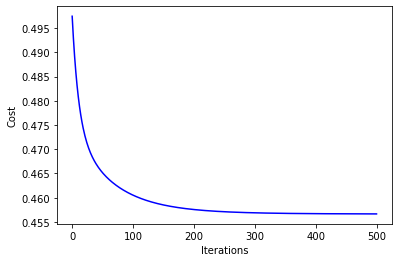

In [16]:
MODEL.train(X_train, y_train, plot_loss_curves=True)

# Greedy Forward Selection

In [17]:
def greedy_fwd(X, y, init_ft = []):
    """
    Greedy forward selection algorithm
    """
    ft = init_ft
    n, d = X.shape
    ls = []
    cnt=1
    while True:
        #print(len(ft), end='\n\n\n\n\n')
        min_cost = np.inf
        best_feature = -1
        for i in range(n):
            if i in ft:
                continue
            #print(i, n)
            #print(X.shape, y.shape)
            #print(X[ft+[i], :].shape, y.shape)
            #MODEL2 = LinearRegression(num_features=X[ft+[i], :].shape[0], learning_rate=0.01, epochs=500, GD='BatchGD')
            cost = LinearRegression(num_features=X[ft+[i], :].shape[0], learning_rate=0.01, epochs=500, GD='BatchGD').train(X[ft+[i], :], y, print_cost=False, plot_loss_curves=False, ret_final_cost=True)
            if cost < min_cost:
                min_cost = cost
                best_feature = i
            #print(i, cost, min_cost)
        if best_feature == -1:
            break
        # print("before: ", ft)
        ft.append(best_feature)
        # print("after: ", ft)
        # print([ft, min_cost])
        # print(len(ft[:cnt]))
        ls.append([ft[:cnt], min_cost])
        cnt+=1
    return ls

In [18]:
greedy_fwd(X_train, y_train)

[[[8], 0.4754344186974244],
 [[8, 6], 0.46148039289968323],
 [[8, 6, 5], 0.45926704931275847],
 [[8, 6, 5, 11], 0.4577816824496525],
 [[8, 6, 5, 11, 9], 0.45739387488823],
 [[8, 6, 5, 11, 9, 7], 0.457184117817872],
 [[8, 6, 5, 11, 9, 7, 4], 0.4569153248473172],
 [[8, 6, 5, 11, 9, 7, 4, 0], 0.45677645453383503],
 [[8, 6, 5, 11, 9, 7, 4, 0, 12], 0.4566311968536072],
 [[8, 6, 5, 11, 9, 7, 4, 0, 12, 3], 0.45662880570721415],
 [[8, 6, 5, 11, 9, 7, 4, 0, 12, 3, 10], 0.456626894552161],
 [[8, 6, 5, 11, 9, 7, 4, 0, 12, 3, 10, 1], 0.45663810359100965],
 [[8, 6, 5, 11, 9, 7, 4, 0, 12, 3, 10, 1, 2], 0.4566544000432227]]

In [19]:
err = [0.4754344186974244,
46148039289968323,0.45926704931275847, 0.4577816824496525, 0.45739387488823,
0.457184117817872,0.4569153248473172,0.45677645453383503,0.4566311968536072,0.45662880570721415,0.456626894552161,0.45663810359100965,0.4566544000432227]

In [20]:
err.sort()

In [21]:
err

[0.456626894552161,
 0.45662880570721415,
 0.4566311968536072,
 0.45663810359100965,
 0.4566544000432227,
 0.45677645453383503,
 0.4569153248473172,
 0.457184117817872,
 0.45739387488823,
 0.4577816824496525,
 0.45926704931275847,
 0.4754344186974244,
 46148039289968323]

In [22]:
a = [8, 6, 5, 11, 9, 7, 4, 0, 12, 3, 10]
colname = data.columns[a]
colname

Index(['grade', 'view', 'waterfront', 'sqft_living15', 'sqft_above',
       'condition', 'floors', 'bedrooms', 'sqft_lot15', 'sqft_lot',
       'sqft_basement'],
      dtype='object')

In [23]:
def greedy_bkwd(X, y):
    """
    Greedy backward algorithm
    """
    n, d = X.shape
    ft = list(range(n))
    sub_ft = ft
    while len(sub_ft)>0:
        min_cost = np.inf
        worst_feature = -1
        for i in range(n):
            if i not in sub_ft:
                continue
            #print(ft, i)
            temp_ft = [x for x in ft if x != i]
            cost = LinearRegression(num_features=X[temp_ft, :].shape[0], learning_rate=0.01, epochs=500, GD='BatchGD').train(X[temp_ft, :], y, print_cost=False, plot_loss_curves=False, ret_final_cost=True)
            if cost < min_cost:
                min_cost = cost
                worst_feature = i
            #print(i, cost, min_cost)
        if worst_feature == -1:
            break
        sub_ft.remove(worst_feature)
        print([sub_ft, min_cost])
        

In [24]:
greedy_bkwd(X_train, y_train)

[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 0.45663810359100965]
[[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 0.456626894552161]
[[0, 3, 4, 5, 6, 7, 8, 9, 11, 12], 0.4566288057072141]
[[0, 4, 5, 6, 7, 8, 9, 11, 12], 0.4566311968536072]
[[0, 4, 5, 6, 7, 8, 9, 11], 0.45677645453383503]
[[4, 5, 6, 7, 8, 9, 11], 0.4569153248473172]
[[4, 5, 6, 7, 8, 11], 0.4570902072421017]
[[4, 5, 6, 8, 11], 0.45742996084089244]
[[5, 6, 8, 11], 0.4577816824496525]
[[5, 6, 8], 0.45926704931275847]
[[6, 8], 0.46148039289968323]
[[8], 0.4754344186974244]
[[], 0.5]


In [25]:
err = [0.45663810359100965, 0.456626894552161, 0.4566288057072141, 0.4566311968536072, 0.45677645453383503, 0.4569153248473172, 0.4570902072421017,
0.45742996084089244, 0.4577816824496525, 0.45926704931275847, 0.46148039289968323, 0.4754344186974244]

In [26]:
err.sort()

In [27]:
err

[0.456626894552161,
 0.4566288057072141,
 0.4566311968536072,
 0.45663810359100965,
 0.45677645453383503,
 0.4569153248473172,
 0.4570902072421017,
 0.45742996084089244,
 0.4577816824496525,
 0.45926704931275847,
 0.46148039289968323,
 0.4754344186974244]

In [28]:
a = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
colname = data.columns[a]
colname

Index(['bedrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'],
      dtype='object')